In [1]:
import pandas as pd
import os 
from src.files import XMLFile, FASTAFile, GBFFFile, InterProScanFile
from src import get_genome_id
from utils import * 
from src.genome import ReferenceGenome
from src.tools import NCBIDatasets, Prodigal
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import dataframe_image as dfi

%load_ext autoreload 
%autoreload 2

In [2]:
genome_metadata_df = load_genome_metadata(refseq_only=True)

model_organisms = ['Pseudomonas aeruginosa', 'Escherichia coli', 'Mycobacterium tuberculosis', 'Bacillus subtilis', 'Aliiviborderrio fischeri'] 
model_organisms += list(genome_metadata_df[(genome_metadata_df.checkm_completeness == 100)].drop_duplicates('class').species)
print('Number of reference genomes:', len(model_organisms))
genome_metadata_df = genome_metadata_df[genome_metadata_df.species.isin(model_organisms)]

for row in genome_metadata_df.itertuples(): 
    input_path = f'../data/genomes/{row.Index}_genomic.fna'
    if os.path.exists(input_path) and (not os.path.exists(f'../data/prodigal/{row.Index}_protein.faa')):
        Prodigal().run(input_path, translation_table=row.ncbi_translation_table)

Number of reference genomes: 51


In [3]:
ncbi_df = pd.read_csv('../data/ncbi_database_cds.csv', index_col=0, dtype={'partial':str}, low_memory=False)

101331 bytes written to file /tmp/tmppvnz1tu9/temp.png


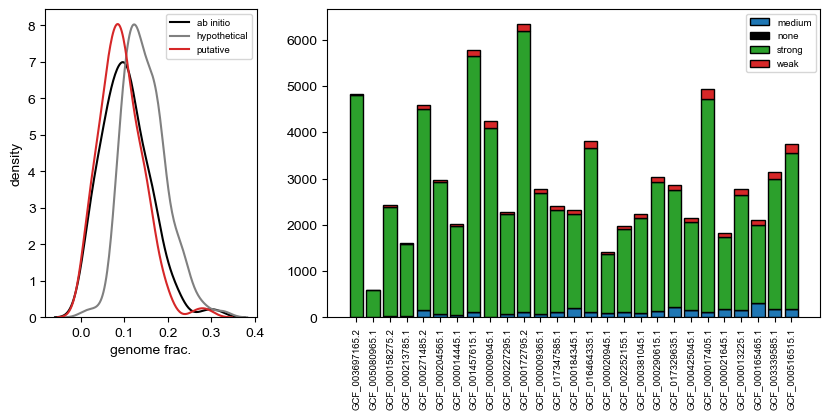

In [ ]:
def figure_1(ncbi_df:pd.DataFrame, path:str='../figures/errors-figure_1.png', genome_ids:list=None):
    # Want to characterize the overall quality of the reference genomes, and possibly exclude some from analysis, depending on how heavily they 
    # are relying on ab initio tools. I should probably add more to this figure. 
    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 4), width_ratios=[0.3, 0.7])
    
    data = dict()
    data['ab initio'] = ncbi_df.groupby('genome_id').apply(lambda df : df.apply(is_ab_initio, axis=1).sum() / len(df), include_groups=False)
    data['hypothetical'] = ncbi_df.groupby('genome_id').apply(lambda df : df.apply(is_hypothetical, axis=1).sum() / len(df), include_groups=False)
    data['putative'] = ncbi_df.groupby('genome_id').apply(lambda df : df.apply(is_putative, axis=1).sum() / len(df), include_groups=False)

    colors = {'ab initio':'black', 'hypothetical':'gray', 'putative':'tab:red'}
    for label, values in data.items():
        sns.kdeplot(values, color=colors[label], ax=ax_a, label=label)
    ax_a.legend(fontsize='x-small', loc='upper right')
    ax_a.set_ylabel('density')
    ax_a.set_xlabel('genome frac.')

    evidence_categories = {'similar to AA sequence':'strong', 'experiment':'strong', 'similar to sequence':'strong', 'protein motif':'medium', 'ab initio prediction':'weak', 'alignment':'strong', np.nan:'none', 'profile':'medium'}
    color_map = {'weak':'tab:red', 'medium':'tab:blue', 'none':'black', 'strong':'tab:green'}
    
    ncbi_df = ncbi_df.copy()
    ncbi_df['evidence_type'] = ncbi_df.evidence_type.replace(evidence_categories)
    positions = np.arange(len(genome_ids))
    bottom = np.zeros(len(genome_ids))
    for evidence_type, df in ncbi_df.groupby('evidence_type'):
        heights = [(df.genome_id == genome_id).sum() for genome_id in genome_ids]
        ax_b.bar(positions, heights, color=color_map[evidence_type], edgecolor='black', label=evidence_type, bottom=bottom)
        bottom += heights
    ax_b.set_xticks(positions, labels=genome_ids, rotation=90, fontsize='x-small')
    ax_b.legend(fontsize='x-small')

    plt.savefig(path, dpi=500)
    plt.show()


def table_1(ncbi_df:pd.DataFrame, path:str='../figures/errors-table_1.png', max_frac_putative:float=0.05):
    table_df = dict()
    table_df['num. putative'] = ncbi_df.groupby('genome_id', sort=True).apply(lambda df : df.apply(is_putative, axis=1).sum(), include_groups=False)
    table_df['frac. putative'] = ncbi_df.groupby('genome_id', sort=True).apply(lambda df : df.apply(is_putative, axis=1).sum() / len(df), include_groups=False)
    table_df = pd.DataFrame(table_df, index=sorted(ncbi_df.genome_id.unique()))
    table_df = table_df.sort_values(by='frac. putative', ascending=True)
    table_df = table_df[table_df['frac. putative'] < max_frac_putative]
    dfi.export(table_df, path)
    return table_df


table_1_df = table_1(ncbi_df)
figure_1(ncbi_df, genome_ids=table_1_df.index)


In [56]:
ref_out_df = load_ref_out()
ref_out_df = remove_partial(ref_out_df)

remove_partial: Removing 4309 instances marked as partial by both Prodigal and NCBI from the DataFrame.


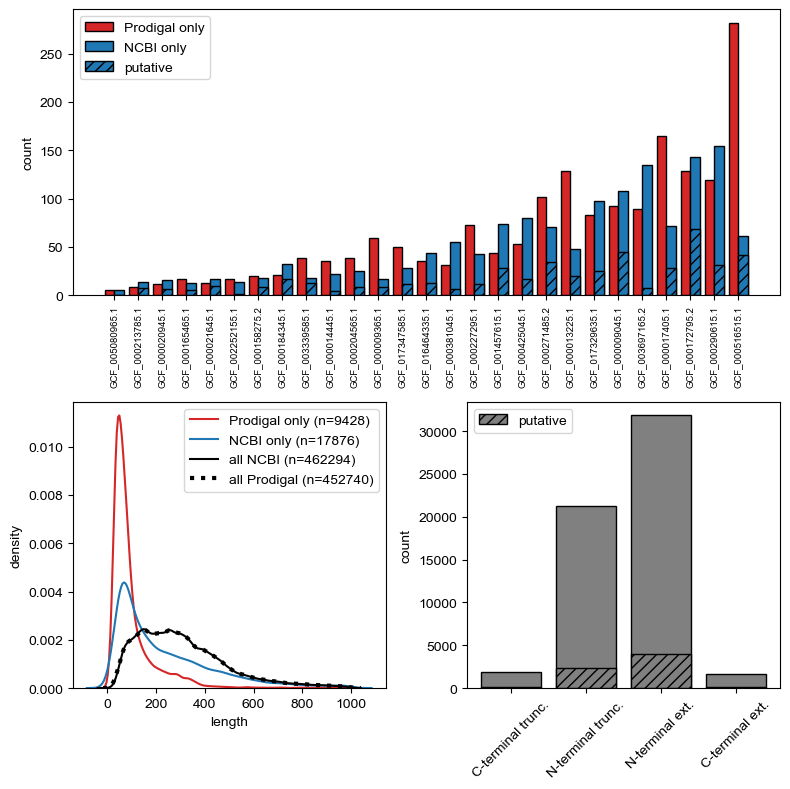

In [6]:
# What are the length distributions of Prodigal sequences which don't have a hit in RefSeq, and the ones in RefSeq that Prodigal missed?
# Is there any connection between genome characteristics, like GC content, and Prodigal performance?

def figure_2(ref_out_df:pd.DataFrame, ncbi_df:pd.DataFrame, genome_ids:list=None, max_length:int=1000, path:str='../figures/errors-figure_2.png'):

    fig = plt.figure(layout='tight', figsize=(8, 8))
    grid = GridSpec(nrows=2, ncols=2)

    ax_a = fig.add_subplot(grid[0, :])
    ax_b = fig.add_subplot(grid[1, 0])
    ax_c = fig.add_subplot(grid[1, 1])

    ncbi_df['length'], ref_out_df['length'] = get_lengths(ncbi_df, ref=False), get_lengths(ref_out_df, ref=False)
    ncbi_df, ref_out_df = ncbi_df[ncbi_df.length < max_length], ref_out_df[ref_out_df.length < max_length]

    prodigal_only_df = ref_out_df[ref_out_df.n_valid_hits == 0]
    ncbi_only_df = ncbi_df[~ncbi_df.protein_id.isin(ref_out_df.ref_protein_id)]

    ax_a_df = pd.DataFrame(index=ncbi_df.genome_id.drop_duplicates())
    ax_a_df['putative'] = ncbi_only_df.groupby('genome_id', sort=False).apply(lambda df : df.apply(is_putative, axis=1).sum(), include_groups=False)
    ax_a_df['Prodigal only'] = prodigal_only_df.groupby('genome_id', sort=False).apply(len, include_groups=False)
    ax_a_df['NCBI only'] = ncbi_only_df.groupby('genome_id', sort=False).apply(len, include_groups=False)
    ax_a_df['total'] = ax_a_df['Prodigal only'] + ax_a_df['NCBI only']
    ax_a_df = ax_a_df.sort_values('total', ascending=True, ignore_index=False)
    if genome_ids is not None:
        ax_a_df = ax_a_df[ax_a_df.index.isin(genome_ids)]

    width = 0.4
    colors = {'NCBI only':'tab:blue', 'Prodigal only':'tab:red'}
    positions = np.arange(len(ax_a_df))
    for i, label in enumerate(['Prodigal only', 'NCBI only']):
        ax_a.bar(positions + i * width, ax_a_df[label], width=width,  color=colors[label], edgecolor='black', label=label)
    ax_a.bar(positions + width, ax_a_df['putative'], width=width,  color='tab:blue', edgecolor='black', label='putative', hatch='///')
    ax_a.set_xticks(positions + width / 2, labels=ax_a_df.index, fontsize='x-small', rotation=90)   
    ax_a.legend()
    ax_a.set_ylabel('count')


    sns.kdeplot(prodigal_only_df.length, ax=ax_b, label=f'Prodigal only (n={len(prodigal_only_df)})', color='tab:red')
    sns.kdeplot(ncbi_only_df.length, ax=ax_b, label=f'NCBI only (n={len(ncbi_only_df)})', color='tab:blue')
    sns.kdeplot(ncbi_df.length, ax=ax_b, label=f'all NCBI (n={len(ncbi_df)})', color='black')
    sns.kdeplot(ref_out_df.length, ax=ax_b, label=f'all Prodigal (n={len(ref_out_df)})', lw=3, ls=':', markersize=1, color='black')
    ax_b.set_ylabel('density')
    ax_b.set_xlabel('length')
    ax_b.legend()


    funcs = {'C-terminal trunc.':is_c_trunc, 'N-terminal trunc.':is_n_trunc, 'N-terminal ext.':is_n_ext, 'C-terminal ext.':is_c_ext}
    ax_c_df = pd.DataFrame({col:ref_out_df.apply(func, axis=1) for col, func in funcs.items()})
    positions = np.arange(len(ax_c_df.columns))
    ax_c.bar(positions, ax_c_df.sum(axis=0), edgecolor='black', color='gray')
    ax_c.bar(positions, ax_c_df[ref_out_df.apply(is_putative, axis=1)].sum(axis=0), edgecolor='black', color='gray', hatch='///', label='putative')
    ax_c.legend()
    ax_c.set_ylabel('count')
    ax_c.set_xticks(positions, labels=ax_c_df.columns, rotation=45)

    fig.savefig(path, dpi=500)
    plt.show()

figure_2(ref_out_df, ncbi_df, genome_ids=table_1_df.index)

/tmp/ipykernel_3782850/857706121.py:30: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_.trunc_size.astype(np.float64), ax=ax, color=colors[category], label=category)


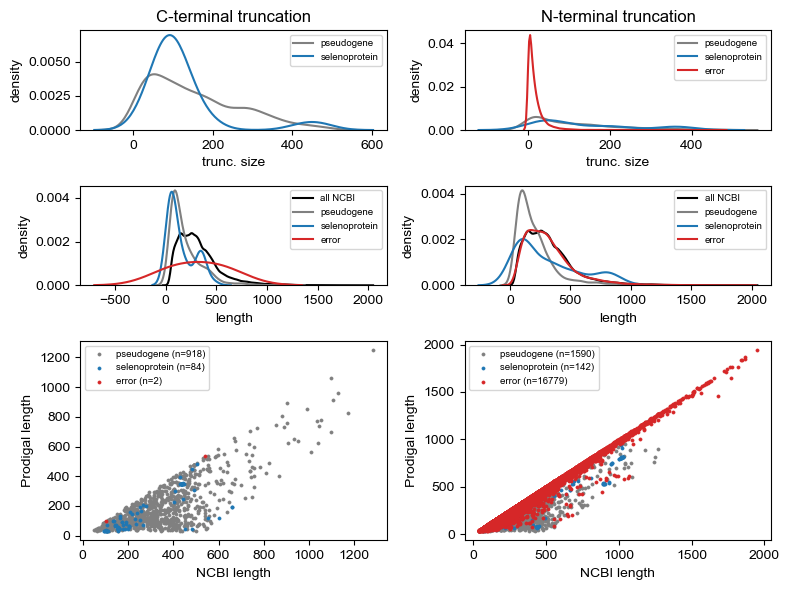

In [55]:
def figure_3(ref_out_df:pd.DataFrame, max_length:int=2000, max_trunc_size:int=500, remove_putative:bool=True, path:str='../figures/errors-figure_3.png'):

    fig, axes = plt.subplots(ncols=2, nrows=3, layout='tight', sharey=False, figsize=(8, 6), height_ratios=[0.25, 0.25, 0.5])
    axes[0, 1].set_title('N-terminal truncation')
    axes[0, 0].set_title('C-terminal truncation')
    colors = {'selenoprotein':'tab:blue', 'error':'tab:red', 'pseudogene':'gray'}

    # Filter out the hits which were in-frame, but not aligned at either end. There are only about 1700 of these.
    df = ref_out_df[(ref_out_df.start_aligned_hit | ref_out_df.stop_aligned_hit)].copy()
    df = df[df.apply(lambda row : is_c_trunc(row) or is_n_trunc(row), axis=1)]

    categories = np.where(df.ref_pseudo.astype(bool), 'pseudogene', 'error')
    categories = np.where(df.ref_seq.str.contains('U') & ~df.ref_pseudo.astype(bool), 'selenoprotein', categories)
    df['category'] = pd.Categorical(categories, ['pseudogene', 'selenoprotein', 'error'], ordered=True)
    df['length'] = get_lengths(df, ref=False)
    df['ref_length'] = get_lengths(df, ref=True)
    df['trunc_size'] = df.ref_length - df.length
    if max_length is not None:
        df = df[df.ref_length < max_length]
    if max_trunc_size is not None:
        df = df[df.trunc_size < max_trunc_size]
    if remove_putative:
        df = df[~df.apply(is_putative, axis=1)]

    # Split the Dataframe into N- and C-terminal truncations. 
    dfs = [df[df.apply(is_c_trunc, axis=1)], df[df.apply(is_n_trunc, axis=1)]]

    for ax, df in zip(axes[0], dfs):
        for category, df_ in df.groupby('category', observed=True):
            sns.kdeplot(df_.trunc_size.astype(np.float64), ax=ax, color=colors[category], label=category)
        ax.set_xlabel('trunc. size')
        ax.set_ylabel('density')
        ax.legend(fontsize='x-small')

    for ax, df in zip(axes[1], dfs):
        lengths = get_lengths(ref_out_df, ref=True)
        lengths = lengths[lengths < max_length] if (max_length is not None) else lengths
        sns.kdeplot(lengths, ax=ax, color='black', label='all NCBI')

        for category, df_ in df.groupby('category', observed=True):
            sns.kdeplot(df_.length, ax=ax, color=colors[category], label=category)
        ax.set_xlabel('length')
        ax.set_ylabel('density')
        ax.legend(fontsize='x-small')

    for ax, df in zip(axes[2], dfs):
        for category, df_ in df.groupby('category', sort=True, observed=True):
            ax.scatter(df_.ref_length, df_.length, color=colors[category], s=5, lw=0.5, label=f'{category} (n={len(df_)})')
        ax.legend(fontsize='x-small')
        ax.set_ylabel('Prodigal length')
        ax.set_xlabel('NCBI length')

    fig.savefig(path, dpi=500, format='png')
    plt.show()

figure_3(ref_out_df)

In [8]:
# I need a new set of criteria to decide if a sequence is spurious or not, other than the sequence simply having a hit in the reference. We have several cases. 
#   1. Prodigal genes with hits in the reference, but the reference hit is (i) a hypothetical protein, (ii) only has ab initio evidence, and (iii) could not be 
#       annotated by InterProScan (suggests that the sequence might be a mistake made by both Prodigal and PGAP)
#   2. Prodigal genes with no hits in the reference, but could be annotated by InterProScan (suggests that it is a real protein that was missed by PGAP).
#   3. Prodigal genes with no hits in the reference, and could not be annotated by InterProScan. 
#   4. Prodigal genes with hits in the reference that have decent homology-based evidence (these are probably safe to include in the "negative" training set). 

In [ ]:
putative_df = ref_out_df[ref_out_df.apply(is_putative, axis=1)].copy()
putative_df = putative_df[~(putative_df.ref_pseudo.astype(bool))].copy() # Remove the putative pseudogenes, which means we can't use InterPro to check them. 
putative_df.seq = putative_df.ref_seq # We want to run InterProScan on the reference sequence, not the Prodigal sequence. 
putative_df = pd.concat([putative_df, ref_out_df[~ref_out_df.apply(has_ref_hit, axis=1)]]) # Add the Prodigal sequences without hits in the reference. 
# Write the sequences to a FASTA file for running InterProScan. 
file = FASTAFile(df=putative_df)
file.write('../data/putative_protein.faa')
# ~/interproscan/interproscan-5.73-104.0/interproscan.sh -i putative_protein.faa -verbose -f tsv

interpro_df = InterProScanFile('../data/putative_protein.interpro.tsv').to_df(max_e_value=1e-5, drop_duplicates=True)
interpro_df.columns = ['interpro_' + col for col in interpro_df.columns]
ref_out_df = ref_out_df.merge(interpro_df, left_index=True, right_index=True, how='left', validate='one_to_one')

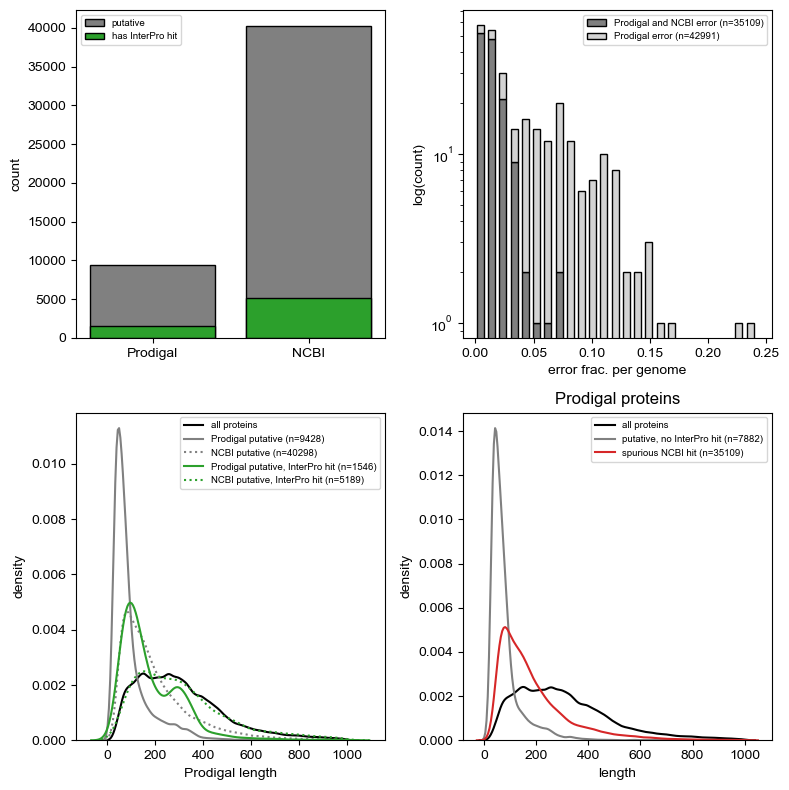

In [54]:
# What fraction of the putative Prodigal and NCBI genes are spurious?
# How many genes per genome does it seem like NCBI misses, but Prodigal finds?
# How many spurious genes per genome from Prodigal? What about from NCBI?
def figure_3(ref_out_df, max_length:int=1000, path:str='../figures/errors-figure_3.png'):

    df = ref_out_df[['genome_id']].copy()
    df['ncbi_error'] = ref_out_df.apply(is_ncbi_error, axis=1)
    df['ncbi_putative'] = ref_out_df.apply(is_putative, axis=1)
    df['prodigal_error'] = ref_out_df.apply(is_prodigal_error, axis=1)
    df['prodigal_putative'] = ~ref_out_df.apply(has_ref_hit, axis=1)
    df['length'] = get_lengths(ref_out_df, ref=False)
    df['has_ref_hit'] = ref_out_df.apply(has_ref_hit, axis=1)
    df['has_interpro_hit'] = ref_out_df.apply(has_interpro_hit, axis=1)
    if max_length is not None:
        df = df[df.length < max_length]

    n_prodigal_error = df.prodigal_error.sum()
    n_prodigal_and_ncbi_error = (df.prodigal_error & df.ncbi_error).sum()
    # print((~df.prodigal_error & df.ncbi_error).sum())

    # fig, (ax_a, ax_b) = plt.subplots(nrows=2, figsize=(8, 4))
    fig = plt.figure(figsize=(8, 8), layout='tight')
    grid = GridSpec(nrows=2, ncols=2, figure=fig)
    ax_a = fig.add_subplot(grid[0, 0])
    ax_b = fig.add_subplot(grid[0, 1])
    ax_c = fig.add_subplot(grid[1, 0])
    ax_d = fig.add_subplot(grid[1, 1])

    ax_a.bar([0], df.prodigal_putative.sum(), color='gray', edgecolor='black', label='putative')
    ax_a.bar([0], (df.prodigal_putative & df.has_interpro_hit).sum(), color='tab:green', edgecolor='black', label='has InterPro hit')
    ax_a.bar([1], df.ncbi_putative.sum(), color='gray', edgecolor='black')
    ax_a.bar([1], (df.ncbi_putative & df.has_interpro_hit).sum(), color='tab:green', edgecolor='black')
    ax_a.set_ylabel('count')
    ax_a.set_xticks([0, 1], labels=['Prodigal', 'NCBI'])
    ax_a.legend(fontsize='x-small', loc='upper left')

    ax_b_data = list()
    ax_b_data += [df.groupby('genome_id').apply(lambda df : (df.prodigal_error & ~df.ncbi_error).sum() / len(df), include_groups=False)]
    ax_b_data += [df.groupby('genome_id').apply(lambda df : (df.prodigal_error & df.ncbi_error).sum() / len(df), include_groups=False)]

    labels = [f'Prodigal and NCBI error (n={n_prodigal_and_ncbi_error})', f'Prodigal error (n={n_prodigal_error})']
    kwargs = {'color':['gray', 'lightgray'], 'edgecolor':'black'} # , bins=25, 
    ax_b.hist(ax_b_data, bins=25, stacked=True, width=0.006, label=labels, **kwargs)
    ax_b.set_yscale('log')
    ax_b.set_xlabel('error frac. per genome')
    ax_b.set_ylabel('log(count)')
    ax_b.legend(fontsize='x-small')

    ax_c_data = dict()
    ax_c_data['Prodigal putative'] = df[df.prodigal_putative].length
    ax_c_data['NCBI putative'] = df[df.ncbi_putative].length
    ax_c_data['Prodigal putative, InterPro hit'] = df[df.prodigal_putative & df.has_interpro_hit].length
    ax_c_data['NCBI putative, InterPro hit'] = df[df.ncbi_putative & df.has_interpro_hit].length
    
    colors = {'Prodigal putative':'gray', 'NCBI putative':'gray', 'Prodigal putative, InterPro hit':'tab:green', 'NCBI putative, InterPro hit':'tab:green'}
    linestyles = {'Prodigal putative':'-', 'NCBI putative':':', 'Prodigal putative, InterPro hit':'-', 'NCBI putative, InterPro hit':':'}
    
    sns.kdeplot(df.length, color='black', label=f'all proteins', ax=ax_c)
    for label, lengths in ax_c_data.items():
        sns.kdeplot(lengths, color=colors[label], label=f'{label} (n={len(lengths)})', ls=linestyles[label], ax=ax_c)
    ax_c.set_ylabel('density')
    ax_c.set_xlabel('Prodigal length')
    ax_c.legend(fontsize='x-small')

    ax_d.set_title('Prodigal proteins')
    ax_d_data = dict()
    ax_d_data['putative, no InterPro hit'] = df[df.prodigal_putative & ~df.has_interpro_hit].length
    ax_d_data['spurious NCBI hit'] = df[df.has_ref_hit & df.ncbi_error].length

    colors = {'putative, no InterPro hit':'gray','spurious NCBI hit':'tab:red'}

    sns.kdeplot(df.length, color='black', label=f'all proteins', ax=ax_d)
    for label, lengths in ax_d_data.items():
        sns.kdeplot(lengths, color=colors[label], label=f'{label} (n={len(lengths)})', ax=ax_d)
    ax_d.set_ylabel('density')
    ax_d.set_xlabel('length')
    ax_d.legend(fontsize='x-small')

    fig.savefig(path, dpi=500)
    plt.show()

figure_3(ref_out_df)